### Imports

In [1]:
import os
os.chdir("..")

from functools import partial

from src import evaluate
import utils
from utils import data_loaders
from src.train_test import fit_class
from src.train_test import test_class
from src import model

import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchmetrics as tm
import pyro
import pyro.distributions as dist
import tyxe
from utils.domain_split import hyperplane_split
from utils.domain_split import hypersphere_split
#npr.seed(42)
#torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Read diabetes data

In [2]:
# Diabetes dataset
df = pd.read_csv("data/classification/diabetes.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Separate to in-domain / OOD data with a hyperplane

Note: this method still treats all of the variables as continuous.

In [3]:
D = df.values

dom_idx, OOD_idx = hyperplane_split(D, OOD_size=0.2, verbose=1)

df[dom_idx].head()

Found random direction n = [ 0.00291585  0.36487657  0.23959316  0.34215381 -0.57152771  0.4429624
  0.29465054 -0.28603365  0.02981058]
Found split with ratio r = 0.20052083333333334


,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### We continue the training / testing pipeline with in-domain data only

In [4]:
# Minmax scaling for better network performace
scaler = MinMaxScaler()
D = df[dom_idx].values
D = scaler.fit_transform(D)

# Split in-domain data to data and labels
X, y = D[:,:-1], D[:,-1]

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

# Separate OOD data
OOD = df[OOD_idx].values
OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

### Set network and batch size hyperparameters

In [5]:
# Hyperparameters
n_classes = len(set(y))
n_features = X.shape[1]
n_epochs = 1000
n_hidden_1 = 30
n_hidden_2 = 30
learning_rate = 1e-3
weight_decay = 1e-4
batch_size_train = 64
batch_size_test = 64

### Prepare tensor dataset and loaders to pytorch format

In [6]:
# Tensor datasets
train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=True)
test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=True)
OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=True)

# Data loaders on gpu
train_loader = data_loaders.create_loader(train_dataset, batch_size_train, 'cuda')
test_loader = data_loaders.create_loader(test_dataset, batch_size_test, 'cuda')
OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size_test, 'cuda')

### Model setup

In [7]:
diabetes_model = model.diabetes_laplace(n_features, n_hidden_1, n_hidden_2).to(device)

### Optimizer

In [8]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(diabetes_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

### Fit the model

In [9]:
# Train the model
train_losses = fit_class(diabetes_model, loss_function, optimizer, train_loader, n_epochs=n_epochs,
               verbose=0, early_stopping=False, return_loss=True)

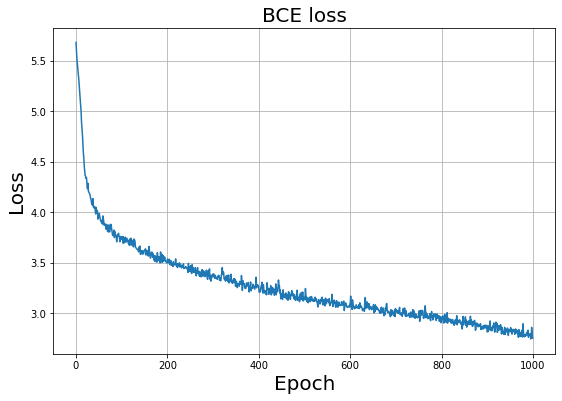

In [10]:
plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("BCE loss", fontsize=20)
plt.show()

### Test accuracy

In [11]:
test_class(diabetes_model, loss_function, test_loader)


Accuracy: 89/123 = 72.35771942138672%


### OOD accuracy

In [12]:
# Test the model
test_class(diabetes_model, loss_function, OOD_loader, return_loss=True, return_acc=True, rounded=5)


Accuracy: 119/154 = 77.2727279663086%


(2.077379584312439, 0.772727279663086)

### Now that we have a pipeline ready, let's use 10-fold cross validation to see the performance on the whole data

In [13]:
def pipeline(X_train, X_test, y_train, y_test, verbose=0):

    # Tensor datasets and data loaders on gpu
    train_dataset = data_loaders.create_torch_dataset(X_train, y_train)
    test_dataset = data_loaders.create_torch_dataset(X_test, y_test)
    train_loader = data_loaders.create_loader(train_dataset, batch_size_train, 'cuda')
    test_loader = data_loaders.create_loader(test_dataset, batch_size_test, 'cuda')

    # Model setup
    diabetes_model = model.diabetes_laplace(n_features, n_hidden_1, n_hidden_2).to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(diabetes_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # fit function optionally returns a list with the epoch-wise losses
    train_loss, train_acc = fit_class(diabetes_model, loss_function, optimizer, train_loader, n_epochs=n_epochs,
                           verbose=0, early_stopping=False, return_loss=True, return_acc=True) 
    test_loss, test_acc = test_class(diabetes_model, loss_function, test_loader, verbose=0, 
                                     return_loss=True, return_acc=True) 
    
    if verbose:
        print(f"Total train loss for this fold: {train_loss[-1] : .6f}")
        print(f"Average Train Cross-Entropy Loss: {train_loss[-1] / len(X_train) : .10f}")
        print(f"Total test loss for this fold: {test_loss : .6f}")
        print(f"Average Test Cross-Entropy Loss : {test_loss / len(X_test) : .10f}" )

    return train_acc, test_acc                # train acc is a list, test acc is a float
 


Training on fold no. 1

Accuracy: 43/62 = 69.3548355102539%
Total train loss for this fold:  3.309070
Average Train Cross-Entropy Loss:  0.0059946926
Total test loss for this fold:  0.670801
Average Test Cross-Entropy Loss :  0.0108193774

Training on fold no. 2

Accuracy: 52/62 = 83.87096405029297%
Total train loss for this fold:  3.159145
Average Train Cross-Entropy Loss:  0.0057230895
Total test loss for this fold:  0.508088
Average Test Cross-Entropy Loss :  0.0081949667

Training on fold no. 3

Accuracy: 39/62 = 62.90322494506836%
Total train loss for this fold:  3.295943
Average Train Cross-Entropy Loss:  0.0059709118
Total test loss for this fold:  1.015779
Average Test Cross-Entropy Loss :  0.0163835249

Training on fold no. 4

Accuracy: 42/62 = 67.74192810058594%
Total train loss for this fold:  2.966712
Average Train Cross-Entropy Loss:  0.0053744783
Total test loss for this fold:  0.601730
Average Test Cross-Entropy Loss :  0.0097053301

Training on fold no. 5

Accuracy: 44

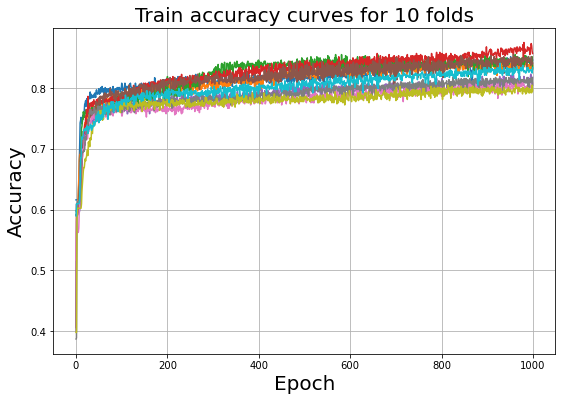

In [14]:
n_splits = 10
kf = KFold(n_splits)

train_accs = np.zeros(n_splits)
test_accs = np.zeros(n_splits)
train_accs_plot = []                           # for plotting loss curves
for i, (train_index, test_index) in enumerate(kf.split(X)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("\nTraining on fold no. %d" %(i+1))
    epoch_wise_train_accs, test_accs[i] = pipeline(X_train, X_test, y_train, y_test, verbose=1)
    train_accs[i] = epoch_wise_train_accs[-1]
    train_accs_plot.append(epoch_wise_train_accs)
    
print("Train accuracies:", train_accs)
print("Test accuracies:", test_accs)

avg_train_acc_k_folds = train_accs.mean()
avg_test_acc_k_folds = test_accs.mean()
print(f"\nAvg train accuracy over all folds: {avg_train_acc_k_folds :.5f}")
print(f"Avg test accuracy over all folds: {avg_test_acc_k_folds :.5f}")

plt.figure(figsize=(9,6))
for accs in train_accs_plot:
    accs = [acc.cpu().detach().numpy() for acc in accs]
    plt.plot(accs)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Train accuracy curves for 10 folds", fontsize=20)
plt.show()

## Bayesian NN

Let's sample from the posterior of the corresponding Bayesian NN using HMC and TyXe.

In [15]:
# Only run this cell to select different domain split

def reset():
    # Data
    dom_idx, OOD_idx = hyperplane_split(df.values, OOD_size=0.2, verbose=1)

    # Minmax scaling for better network performace
    scaler = MinMaxScaler()
    D = df[dom_idx].values
    D = scaler.fit_transform(D)

    # Split in-domain data to data and labels
    X, y = D[:,:-1], D[:,-1]

    # Split to train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

    # Separate OOD data
    OOD = df[OOD_idx].values
    OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
    X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

    # Split to train / test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)


    # Tensor datasets
    train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=True)
    test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=True)
    OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=True)

    # Data loaders on gpu
    train_loader = data_loaders.create_loader(train_dataset, batch_size_train, 'cuda')
    test_loader = data_loaders.create_loader(test_dataset, batch_size_test, 'cuda')
    OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size_test, 'cuda')
    
    pass

# reset()

In [16]:
train_size = len(X_train)
test_size = len(X_test)

# Model 
net = model.diabetes_laplace(n_features, n_hidden_1, n_hidden_2).to(device)
prior = tyxe.priors.IIDPrior(
    dist.Normal(
        torch.tensor(0, device=device, dtype=torch.float),
        torch.tensor(1, device=device, dtype=torch.float),
    ),
)
prior_name = ", IID prior"
likelihood = tyxe.likelihoods.Categorical(train_size)
likelihood_name = ", Categorical likelihood"
kernel = partial(pyro.infer.mcmc.HMC, step_size=1e-3, num_steps=20, target_accept_prob=0.7)
kernel_name = "HMC"
bnn = tyxe.bnn.MCMC_BNN(net, prior, likelihood, kernel)
bnn.name = kernel_name + ", MCMC BNN" + likelihood_name + prior_name

# Fit
pyro.clear_param_store()
bnn.fit(train_loader, 100000, warmup_steps=30000)

Sample: 100%|███████████████████████████████████| 130000/130000 [30:45, 70.45it/s, step size=2.20e-02, acc. prob=0.890]


In [21]:
# Predict
posterior_samples = 10000        # how many posterior "networks" to use for prediction

train_evaluation = evaluate.evaluate_class(
    model=bnn, 
    loader=train_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, Train data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

test_evaluation = evaluate.evaluate_class(
    model=bnn, 
    loader=test_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, Test data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

OOD_evaluation = evaluate.evaluate_class(
    model=bnn, 
    loader=OOD_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, OOD data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)


print("Train evaluation:")
for key,  value in train_evaluation.items():
    print(key + str(":"), value)
    
print("\nTest evaluation:")
for key,  value in test_evaluation.items():
    print(key + str(":"), value)
    
print("\nOOD evaluation:")
for key,  value in OOD_evaluation.items():
    print(key + str(":"), value)

Train evaluation:
Inference type: HMC, MCMC BNN, Categorical likelihood, IID prior
Evaluated on: Diabetes, Train data
Number of posterior samples: 10000
Average NLPD: 0.3960677981
Average accuracy: 0.8187372684
Average AUROC: 0.898447752
Average ECE: 0.0493310727

Test evaluation:
Inference type: HMC, MCMC BNN, Categorical likelihood, IID prior
Evaluated on: Diabetes, Test data
Number of posterior samples: 10000
Average NLPD: 0.7017105222
Average accuracy: 0.7073170543
Average AUROC: 0.7742465734
Average ECE: 0.1099061668

OOD evaluation:
Inference type: HMC, MCMC BNN, Categorical likelihood, IID prior
Evaluated on: Diabetes, OOD data
Number of posterior samples: 10000
Average NLPD: 0.3801212311
Average accuracy: 0.8246753216
Average AUROC: 0.8505426645
Average ECE: 0.0727855936


### Variational inference

In [18]:
# Only run this cell to select different domain split

def reset():
    # Data
    dom_idx, OOD_idx = hyperplane_split(df.values, OOD_size=0.2, verbose=1)

    # Minmax scaling for better network performace
    scaler = MinMaxScaler()
    D = df[dom_idx].values
    D = scaler.fit_transform(D)

    # Split in-domain data to data and labels
    X, y = D[:,:-1], D[:,-1]

    # Split to train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

    # Separate OOD data
    OOD = df[OOD_idx].values
    OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
    X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

    # Split to train / test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

    # Tensor datasets
    train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=True)
    test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=True)
    OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=True)

    # Data loaders on gpu
    train_loader = data_loaders.create_loader(train_dataset, batch_size_train, 'cuda')
    test_loader = data_loaders.create_loader(test_dataset, batch_size_test, 'cuda')
    OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size_test, 'cuda')
    
    pass

# reset()

In [22]:
train_size = len(X_train)
test_size = len(X_test)

# Model 
var_net = model.diabetes_laplace(n_features, n_hidden_1, n_hidden_2).to(device)
prior = tyxe.priors.IIDPrior(
    dist.Normal(
        torch.tensor(0, device=device, dtype=torch.float),
        torch.tensor(1, device=device, dtype=torch.float),
    ),
)
prior_name = ", IID prior"
obs_model = tyxe.likelihoods.Categorical(train_size)
likelihood_name = ", Categorical likelihood"
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
guide_name = "Mean field"
var_bnn = tyxe.VariationalBNN(var_net, prior, obs_model, guide_builder)
var_bnn.name = guide_name + " Variational BNN" + likelihood_name + prior_name

# Fit
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []    
def callback(bnn, i, e):
    elbos.append(e)
var_bnn.fit(train_loader, optim, n_epochs, callback, device=device)

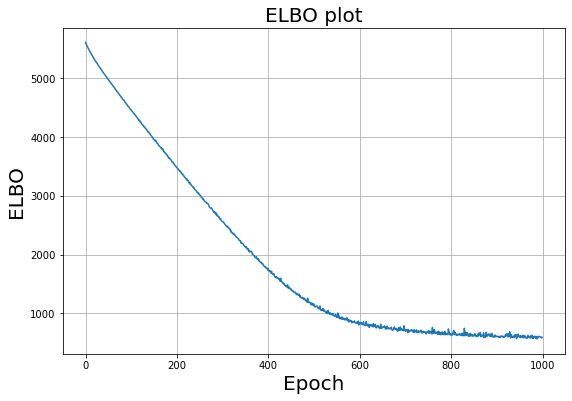

Train evaluation:
Inference type: Mean field Variational BNN, Categorical likelihood, IID prior
Evaluated on: Diabetes, Train data
Number of posterior samples: 10000
Average NLPD: 0.5009188056
Average accuracy: 0.7657840848
Average AUROC: 0.8437219858
Average ECE: 0.0827813447

Test evaluation:
Inference type: Mean field Variational BNN, Categorical likelihood, IID prior
Evaluated on: Diabetes, Test data
Number of posterior samples: 10000
Average NLPD: 0.5398668647
Average accuracy: 0.7723577023
Average AUROC: 0.7887670994
Average ECE: 0.1129497364

OOD evaluation:
Inference type: Mean field Variational BNN, Categorical likelihood, IID prior
Evaluated on: Diabetes, OOD data
Number of posterior samples: 10000
Average NLPD: 0.4539698064
Average accuracy: 0.7532467246
Average AUROC: 0.8294574022
Average ECE: 0.0956760198


In [23]:
# Predict
posterior_samples = 10000        # how many posterior "networks" to use for prediction

train_evaluation = evaluate.evaluate_class(
    model=var_bnn, 
    loader=train_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, Train data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

test_evaluation = evaluate.evaluate_class(
    model=var_bnn, 
    loader=test_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, Test data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)

OOD_evaluation = evaluate.evaluate_class(
    model=var_bnn, 
    loader=OOD_loader, 
    posterior_samples=posterior_samples, 
    dataset='Diabetes, OOD data', 
    num_classes=n_classes, 
    device=device,
    rounded=10)


# Plot
plt.figure(figsize=(9,6))
plt.plot(elbos)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("ELBO", fontsize=20)
plt.title("ELBO plot", fontsize=20)
plt.show()


print("Train evaluation:")
for key,  value in train_evaluation.items():
    print(key + str(":"), value)
    
print("\nTest evaluation:")
for key,  value in test_evaluation.items():
    print(key + str(":"), value)
    
print("\nOOD evaluation:")
for key,  value in OOD_evaluation.items():
    print(key + str(":"), value)